# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [4]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [5]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [6]:
env.reset()
rewards = []
for _ in range(100):
    env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [7]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [11]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [12]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state
memory.sample(20)

[(array([-0.03284923, -0.39470805, -0.0391113 ,  0.52901013]),
  0,
  1.0,
  array([-0.04074339, -0.58925857, -0.0285311 ,  0.80911695])),
 (array([-0.06820813, -0.58869572,  0.00950505,  0.79615869]),
  1,
  1.0,
  array([-0.07998204, -0.39370549,  0.02542822,  0.506481  ])),
 (array([-0.19048206, -0.60016607,  0.18935333,  1.06622383]),
  0,
  1.0,
  array([ 0.,  0.,  0.,  0.])),
 (array([-0.04074339, -0.58925857, -0.0285311 ,  0.80911695]),
  0,
  1.0,
  array([-0.05252857, -0.78397819, -0.01234876,  1.09269051])),
 (array([-0.09963968, -0.78476715,  0.0516992 ,  1.11072014]),
  1,
  1.0,
  array([-0.11533502, -0.59036111,  0.0739136 ,  0.83469349])),
 (array([-0.07998204, -0.39370549,  0.02542822,  0.506481  ]),
  0,
  1.0,
  array([-0.08785615, -0.58917635,  0.03555784,  0.8070676 ])),
 (array([ 0.0264543 ,  0.21328323, -0.0408822 , -0.32689267]),
  1,
  1.0,
  array([ 0.03071996,  0.40896266, -0.04742006, -0.63218259])),
 (array([-0.15472207, -0.78904613,  0.1313355 ,  1.21285111

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")


Episode: 1 Total reward: 6.0 Training loss: 1.0669 Explore P: 0.9994
Episode: 2 Total reward: 49.0 Training loss: 1.0460 Explore P: 0.9946
Episode: 3 Total reward: 54.0 Training loss: 1.0767 Explore P: 0.9893
Episode: 4 Total reward: 45.0 Training loss: 1.1019 Explore P: 0.9849
Episode: 5 Total reward: 17.0 Training loss: 1.1378 Explore P: 0.9832
Episode: 6 Total reward: 9.0 Training loss: 1.0055 Explore P: 0.9823
Episode: 7 Total reward: 28.0 Training loss: 1.1226 Explore P: 0.9796
Episode: 8 Total reward: 14.0 Training loss: 1.0640 Explore P: 0.9783
Episode: 9 Total reward: 16.0 Training loss: 1.1311 Explore P: 0.9767
Episode: 10 Total reward: 26.0 Training loss: 1.2047 Explore P: 0.9742
Episode: 11 Total reward: 20.0 Training loss: 1.2354 Explore P: 0.9723
Episode: 12 Total reward: 16.0 Training loss: 2.0586 Explore P: 0.9707
Episode: 13 Total reward: 22.0 Training loss: 1.4309 Explore P: 0.9686
Episode: 14 Total reward: 19.0 Training loss: 1.2255 Explore P: 0.9668
Episode: 15 Total

Episode: 125 Total reward: 11.0 Training loss: 52.7031 Explore P: 0.7942
Episode: 126 Total reward: 15.0 Training loss: 7.1509 Explore P: 0.7930
Episode: 127 Total reward: 9.0 Training loss: 644.8323 Explore P: 0.7923
Episode: 128 Total reward: 15.0 Training loss: 98.9756 Explore P: 0.7911
Episode: 129 Total reward: 11.0 Training loss: 8.2814 Explore P: 0.7902
Episode: 130 Total reward: 12.0 Training loss: 55.3865 Explore P: 0.7893
Episode: 131 Total reward: 16.0 Training loss: 115.4969 Explore P: 0.7881
Episode: 132 Total reward: 13.0 Training loss: 59.0621 Explore P: 0.7871
Episode: 133 Total reward: 11.0 Training loss: 111.3143 Explore P: 0.7862
Episode: 134 Total reward: 8.0 Training loss: 7.1481 Explore P: 0.7856
Episode: 135 Total reward: 20.0 Training loss: 111.4652 Explore P: 0.7840
Episode: 136 Total reward: 10.0 Training loss: 52.5142 Explore P: 0.7833
Episode: 137 Total reward: 12.0 Training loss: 11.2862 Explore P: 0.7823
Episode: 138 Total reward: 18.0 Training loss: 8.425

Episode: 245 Total reward: 12.0 Training loss: 20.0044 Explore P: 0.6525
Episode: 246 Total reward: 19.0 Training loss: 34.4028 Explore P: 0.6513
Episode: 247 Total reward: 22.0 Training loss: 62.7864 Explore P: 0.6499
Episode: 248 Total reward: 16.0 Training loss: 1.6067 Explore P: 0.6489
Episode: 249 Total reward: 14.0 Training loss: 1.1209 Explore P: 0.6480
Episode: 250 Total reward: 21.0 Training loss: 81.6179 Explore P: 0.6466
Episode: 251 Total reward: 23.0 Training loss: 18.4877 Explore P: 0.6452
Episode: 252 Total reward: 14.0 Training loss: 19.4775 Explore P: 0.6443
Episode: 253 Total reward: 9.0 Training loss: 54.0337 Explore P: 0.6437
Episode: 254 Total reward: 9.0 Training loss: 20.1111 Explore P: 0.6431
Episode: 255 Total reward: 10.0 Training loss: 36.3075 Explore P: 0.6425
Episode: 256 Total reward: 16.0 Training loss: 73.6645 Explore P: 0.6415
Episode: 257 Total reward: 11.0 Training loss: 38.8818 Explore P: 0.6408
Episode: 258 Total reward: 11.0 Training loss: 63.6165 

Episode: 358 Total reward: 61.0 Training loss: 1.9773 Explore P: 0.5047
Episode: 359 Total reward: 38.0 Training loss: 1.4251 Explore P: 0.5029
Episode: 360 Total reward: 56.0 Training loss: 12.3909 Explore P: 0.5001
Episode: 361 Total reward: 12.0 Training loss: 1.1052 Explore P: 0.4995
Episode: 362 Total reward: 54.0 Training loss: 9.7862 Explore P: 0.4969
Episode: 363 Total reward: 13.0 Training loss: 28.6355 Explore P: 0.4962
Episode: 364 Total reward: 65.0 Training loss: 0.8292 Explore P: 0.4931
Episode: 365 Total reward: 63.0 Training loss: 1.2430 Explore P: 0.4901
Episode: 366 Total reward: 48.0 Training loss: 32.8294 Explore P: 0.4878
Episode: 367 Total reward: 41.0 Training loss: 30.9056 Explore P: 0.4858
Episode: 368 Total reward: 86.0 Training loss: 1.2496 Explore P: 0.4817
Episode: 369 Total reward: 41.0 Training loss: 12.8734 Explore P: 0.4798
Episode: 370 Total reward: 53.0 Training loss: 1.4630 Explore P: 0.4773
Episode: 371 Total reward: 27.0 Training loss: 17.2112 Expl

Episode: 471 Total reward: 155.0 Training loss: 2.2510 Explore P: 0.2261
Episode: 472 Total reward: 58.0 Training loss: 1.0459 Explore P: 0.2248
Episode: 473 Total reward: 62.0 Training loss: 1.6325 Explore P: 0.2235
Episode: 474 Total reward: 149.0 Training loss: 1.1557 Explore P: 0.2203
Episode: 475 Total reward: 70.0 Training loss: 2.1735 Explore P: 0.2189
Episode: 476 Total reward: 110.0 Training loss: 2.0316 Explore P: 0.2166
Episode: 477 Total reward: 60.0 Training loss: 1.7036 Explore P: 0.2153
Episode: 478 Total reward: 96.0 Training loss: 151.0691 Explore P: 0.2134
Episode: 479 Total reward: 118.0 Training loss: 1.1716 Explore P: 0.2110
Episode: 480 Total reward: 90.0 Training loss: 2.1732 Explore P: 0.2092
Episode: 481 Total reward: 76.0 Training loss: 2.2539 Explore P: 0.2077
Episode: 482 Total reward: 71.0 Training loss: 2.4251 Explore P: 0.2063
Episode: 483 Total reward: 105.0 Training loss: 80.9043 Explore P: 0.2042
Episode: 484 Total reward: 156.0 Training loss: 2.3188 E

Episode: 584 Total reward: 199.0 Training loss: 0.2505 Explore P: 0.0563
Episode: 585 Total reward: 199.0 Training loss: 0.1928 Explore P: 0.0554
Episode: 586 Total reward: 163.0 Training loss: 0.1823 Explore P: 0.0547
Episode: 587 Total reward: 199.0 Training loss: 0.1551 Explore P: 0.0538
Episode: 588 Total reward: 199.0 Training loss: 7.4963 Explore P: 0.0529
Episode: 589 Total reward: 199.0 Training loss: 0.1554 Explore P: 0.0521
Episode: 590 Total reward: 169.0 Training loss: 0.1819 Explore P: 0.0514
Episode: 591 Total reward: 199.0 Training loss: 6.7047 Explore P: 0.0506
Episode: 592 Total reward: 199.0 Training loss: 0.1449 Explore P: 0.0498
Episode: 593 Total reward: 199.0 Training loss: 0.2381 Explore P: 0.0490
Episode: 594 Total reward: 199.0 Training loss: 0.0782 Explore P: 0.0482
Episode: 595 Total reward: 199.0 Training loss: 0.2726 Explore P: 0.0475
Episode: 596 Total reward: 199.0 Training loss: 0.1108 Explore P: 0.0467
Episode: 597 Total reward: 199.0 Training loss: 0.3

Episode: 698 Total reward: 50.0 Training loss: 0.2526 Explore P: 0.0167
Episode: 699 Total reward: 70.0 Training loss: 0.1408 Explore P: 0.0166
Episode: 700 Total reward: 73.0 Training loss: 0.2499 Explore P: 0.0166
Episode: 701 Total reward: 199.0 Training loss: 0.3451 Explore P: 0.0165
Episode: 702 Total reward: 199.0 Training loss: 0.2090 Explore P: 0.0163
Episode: 703 Total reward: 65.0 Training loss: 0.4549 Explore P: 0.0163
Episode: 704 Total reward: 160.0 Training loss: 0.2393 Explore P: 0.0162
Episode: 705 Total reward: 199.0 Training loss: 299.4881 Explore P: 0.0161
Episode: 706 Total reward: 199.0 Training loss: 3.5606 Explore P: 0.0160
Episode: 707 Total reward: 199.0 Training loss: 0.3325 Explore P: 0.0158
Episode: 708 Total reward: 199.0 Training loss: 0.2706 Explore P: 0.0157
Episode: 709 Total reward: 164.0 Training loss: 0.4050 Explore P: 0.0156
Episode: 710 Total reward: 64.0 Training loss: 0.3020 Explore P: 0.0156
Episode: 711 Total reward: 98.0 Training loss: 0.2797 

Episode: 811 Total reward: 194.0 Training loss: 0.5218 Explore P: 0.0110
Episode: 812 Total reward: 170.0 Training loss: 0.7240 Explore P: 0.0110
Episode: 813 Total reward: 17.0 Training loss: 1.3803 Explore P: 0.0110
Episode: 814 Total reward: 15.0 Training loss: 0.9284 Explore P: 0.0110
Episode: 815 Total reward: 13.0 Training loss: 1.3177 Explore P: 0.0110
Episode: 816 Total reward: 13.0 Training loss: 0.9695 Explore P: 0.0110
Episode: 817 Total reward: 12.0 Training loss: 0.7248 Explore P: 0.0110
Episode: 818 Total reward: 12.0 Training loss: 1.2239 Explore P: 0.0110
Episode: 819 Total reward: 16.0 Training loss: 0.8056 Explore P: 0.0110
Episode: 820 Total reward: 16.0 Training loss: 1.2775 Explore P: 0.0110
Episode: 821 Total reward: 12.0 Training loss: 1.3869 Explore P: 0.0110
Episode: 822 Total reward: 11.0 Training loss: 1.8150 Explore P: 0.0110
Episode: 823 Total reward: 8.0 Training loss: 332.6476 Explore P: 0.0110
Episode: 824 Total reward: 10.0 Training loss: 2.3048 Explore

Episode: 927 Total reward: 199.0 Training loss: 0.7789 Explore P: 0.0106
Episode: 928 Total reward: 199.0 Training loss: 330.2552 Explore P: 0.0106
Episode: 929 Total reward: 199.0 Training loss: 2.2346 Explore P: 0.0106
Episode: 930 Total reward: 158.0 Training loss: 3.4729 Explore P: 0.0106
Episode: 931 Total reward: 124.0 Training loss: 2.4024 Explore P: 0.0105
Episode: 932 Total reward: 18.0 Training loss: 482.1606 Explore P: 0.0105
Episode: 933 Total reward: 12.0 Training loss: 3.3058 Explore P: 0.0105
Episode: 934 Total reward: 108.0 Training loss: 1.2161 Explore P: 0.0105
Episode: 935 Total reward: 16.0 Training loss: 4.4538 Explore P: 0.0105
Episode: 936 Total reward: 16.0 Training loss: 262.2675 Explore P: 0.0105
Episode: 937 Total reward: 16.0 Training loss: 49.6329 Explore P: 0.0105
Episode: 938 Total reward: 20.0 Training loss: 1.7059 Explore P: 0.0105
Episode: 939 Total reward: 17.0 Training loss: 486.7465 Explore P: 0.0105
Episode: 940 Total reward: 17.0 Training loss: 27

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [24]:
import matplotlib.pyplot as plt

In [28]:
def mean_cart(x,N):
    cumulative=np.cumsum(np.insert(x,0,0))
    return(cumulative[N:]-cumulative[:-N])/N

In [29]:
eps,rews=np.array(rewards_list).T

In [32]:
smoothed_rews=mean_cart(rews,10)
plt.plot(eps[-len(smoothed_rews):],smoothed_rews)
plt.plot(eps,rews)
plt.xlabel('Episode')
plt.ylabel('Rewards in total')

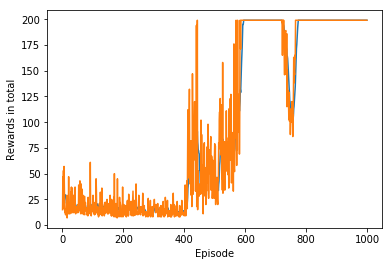

In [33]:
plt.show()

In [16]:
test_episodes=10
test_steps_max=400
with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1,test_episodes):
        t=0
        while(t<test_steps_max):
            env.render()
            feed={mainQN.inputs_:state.reshape((1,*state.shape))}
            Qs=sess.run(mainQN.output,feed_dict=feed)
            action=np.argmax(Qs)
            
            next_state,reward,done,_=env.step(action)
            
            if done:
                t=test_steps_max
                env.reset()
                state,reward,done,_=env.step(env.action_space.sample())
            else:
                state=next_state
                t=t+1
            

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt
